## **Оптимизация алгоритмов машинного обучения с использованием конвейеров (pipeline)**

## Импорт библиотек

In [53]:
import os       # Для работы с файловой системой
import re       # Регулярные выражения

# Для работы с данными
import pandas as pd
import numpy as np
import joblib           # Сохранение моделей
# Исключение warnings
import warnings
warnings.filterwarnings('ignore')

# Основные sklearn модули
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

# Модели регрессии
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Дополнительные модели (ансамблевые бустинги)
import xgboost as xgb
import lightgbm as lgb

# Для визуализации
import matplotlib.pyplot as plt

## Загрузка данных

In [54]:
data_path = 'titanic3.csv'
target_col = 'survived'

In [55]:
data = pd.read_csv(data_path)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,Allen Miss. Elisabeth Walton,female,29.0,0,0,24160,2113375.0,B5,S,2,NaN,St Louis MO
1,1,1,Allison Master. Hudson Trevor,male,9167.0,1,2,113781,1515500.0,C22 C26,S,11,NaN,Montreal PQ / Chesterville ON
2,1,0,Allison Miss. Helen Loraine,female,2.0,1,2,113781,1515500.0,C22 C26,S,NaN,NaN,Montreal PQ / Chesterville ON
3,1,0,Allison Mr. Hudson Joshua Creighton,male,30.0,1,2,113781,1515500.0,C22 C26,S,NaN,135.0,Montreal PQ / Chesterville ON
4,1,0,Allison Mrs. Hudson J C (Bessie Waldo Daniels),female,25.0,1,2,113781,1515500.0,C22 C26,S,NaN,NaN,Montreal PQ / Chesterville ON


## Анализ данных

Общая информация о датасете

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


Статистическое описание числовых столбцов

In [57]:
data.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1.308000e+03,121.000000
mean,2.294882,0.381971,95.855641,0.498854,0.385027,3.329548e+05,160.809917
std,0.837836,0.486055,654.480326,1.041658,0.865560,5.175867e+05,97.696922
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800e+04,72.000000
50%,3.000000,0.000000,29.000000,0.000000,0.000000,1.445420e+05,155.000000
75%,3.000000,1.000000,41.000000,1.000000,0.000000,3.127500e+05,256.000000
max,3.000000,1.000000,9167.000000,8.000000,9.000000,5.123292e+06,328.000000


Проверка пропусков

In [58]:
data.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

## Предобработка данных

Получаем числовые и категориальные колонки

In [59]:
initial_shape = data.shape
print(initial_shape)

(1309, 14)


In [60]:
num_features = data.select_dtypes(include=["int64", "float64"]).columns
cat_features = data.select_dtypes(include=["object"]).columns

print(num_features)
print(cat_features)

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'body'], dtype='object')
Index(['name', 'sex', 'ticket', 'cabin', 'embarked', 'boat', 'home.dest'], dtype='object')


In [61]:
original_len = len(data)
mask = pd.Series([True] * len(data), index=data.index)

for col in num_features:
    # Берем квантили 5% и 95%, чтобы не удалять слишком много данных    
    Q1 = data[col].quantile(0.05)
    Q3 = data[col].quantile(0.95)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    mask = mask & (data[col] >= lower) & (data[col] <= upper)

filtered_data = data[mask].copy()
removed_count = original_len - len(filtered_data)

print(f"Удалено строк: {removed_count} ({removed_count/original_len*100:.2f}%)")
print(f"Осталось строк: {len(filtered_data)}")

Удалено строк: 1217 (92.97%)
Осталось строк: 92


In [62]:
print('Заполнение пропусков..')
# Числовые колонки заполняем медианой
for col in num_features:
    if col != target_col and data[col].isnull().sum() > 0:
        data[col] = SimpleImputer(strategy='median').fit_transform(data[[col]]).ravel()

# Категориальные колонки заполняем модой
for col in cat_features:
    if data[col].isnull().sum() > 0:
        data[col] = SimpleImputer(strategy='most_frequent').fit_transform(data[[col]]).ravel()

print(f"{data.shape} (очищено на {100*(1-data.shape[0]/initial_shape[0]):.1f}%)")

Заполнение пропусков..
(1309, 14) (очищено на 0.0%)


Определяем набор функций для нормализации числовых, и кодировки категориальных признаков

In [63]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

## Подбор гиперпараметров

Так как некоторые колонки могут быть не нужными в обучении, например ID, можно попробовать автоматически их находить и удалять

In [64]:
def get_non_feature_columns(df, threshold_unique=0.05, threshold_missing=0.3):
    '''
    Ф-я для определения потенциальных НЕ-признаковых колонок
    '''
    non_feature_cols = []
    
    for col in df.columns:
        # ID-подобные колонки (почти все значения уникальны)
        unique_ratio = df[col].nunique() / len(df)
        if unique_ratio > 0.95:  # Более 95% уникальных значений
            non_feature_cols.append(col)
            continue
        
        # Колонки с высоким процентом пропусков
        missing_ratio = df[col].isnull().sum() / len(df)
        if missing_ratio > threshold_missing:
            non_feature_cols.append(col)
            continue
        
        # Колонки с текстовыми описаниями (длинный текст)
        if df[col].dtype == 'object':
            # Проверяем среднюю длину строк
            avg_length = df[col].dropna().apply(str).apply(len).mean()
            if avg_length > 100:  # Средняя длина > 100 символов
                non_feature_cols.append(col)
                continue
        
        # Колонки с одним значением (константы)
        if df[col].nunique() == 1:
            non_feature_cols.append(col)
            continue
    
    # Паттерны для определения ID колонок по названию
    id_patterns = [
        r'.*[Ii][Dd]$', r'^[Ii]d$', r'.*[Ii][Dd][_]', r'^id_',
        r'.*[Cc]ode$', r'^code_', r'.*[Nn]umber$',
        r'^passenger', r'^customer', r'^client',
        r'^uuid', r'^guid', r'^key'
    ]
    
    for col in df.columns:
        if col in non_feature_cols:
            continue
            
        col_lower = col.lower()
        for pattern in id_patterns:
            if re.match(pattern, col_lower):
                non_feature_cols.append(col)
                break
    
    return list(set(non_feature_cols))  # Убираем дубликаты

In [65]:
# Определяем целевую переменную и признаки
y = data[target_col]
X = data.drop(columns=[target_col])

# Исключаем не-признаковые колонки
columns_to_drop = get_non_feature_columns(data)
columns_to_drop = [col for col in columns_to_drop if col in X.columns]
X = X.drop(columns=columns_to_drop)

# Обновляем списки признаков после удаления колонок
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print(f"Числовые признаки: {num_features}")
print(f"Категориальные признаки: {cat_features}")
print(f"Размер X: {X.shape}, размер y: {y.shape}")


Числовые признаки: ['pclass', 'age', 'sibsp', 'parch', 'fare', 'body']
Категориальные признаки: ['sex', 'ticket', 'cabin', 'embarked', 'boat', 'home.dest']
Размер X: (1309, 12), размер y: (1309,)


In [66]:
# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # для сохранения распределения классов в задаче классификации
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (1047, 12), Test: (262, 12)


In [67]:
# Создаем трансформеры для числовых и категориальных признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Создаем ColumnTransformer
if num_features and cat_features:
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])
elif num_features:
    preprocessor = numeric_transformer
elif cat_features:
    preprocessor = categorical_transformer
else:
    raise ValueError("Нет признаков для обработки")

print("Пайплайн предобработки создан успешно!")

Пайплайн предобработки создан успешно!


Определяем модели для обучения

In [68]:
# Создаем словарь пайплайнов с моделями
models_pipelines = {
    'LinearRegression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    
    'Ridge': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Ridge(random_state=42))
    ]),
    
    'RandomForest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    
    'GradientBoosting': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ]),
    
    'XGBoost': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(random_state=42, verbosity=0))
    ]),
    
    'LightGBM': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', lgb.LGBMRegressor(random_state=42, verbose=-1))
    ]),
    
    'SVR': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ]),
}

print(f"Создано {len(models_pipelines)} моделей для обучения:")
for model_name in models_pipelines.keys():
    print(f"  - {model_name}")

Создано 7 моделей для обучения:
  - LinearRegression
  - Ridge
  - RandomForest
  - GradientBoosting
  - XGBoost
  - LightGBM
  - SVR


Теперь, нужно определить параметры для "жадного поиска" - алгоритм подбора лучших гиперпараметров у моделей

In [69]:
# Параметры для каждой модели
param_grids = {
    'LinearRegression': {},
    
    'Ridge': {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
    },
    
    'RandomForest': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    },
    
    'GradientBoosting': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5],
        'regressor__min_samples_split': [2, 5]
    },
    
    'XGBoost': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__subsample': [0.8, 1.0]
    },
    
    'LightGBM': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [5, 10, -1],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__num_leaves': [31, 50, 100]
    },
    
    'SVR': {
        'regressor__C': [0.1, 1.0, 10.0],
        'regressor__kernel': ['linear', 'rbf']
    },
}

## Обучение модели

In [70]:
# Создаем кастомную метрику RMSE
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

In [71]:
# Словари для хранения результатов
results = {}
best_models = {}

# Проходим по всем моделям
for model_name, pipeline in models_pipelines.items():
    print(f"\n{'='*60}")
    print(f"МОДЕЛЬ: {model_name}")
    print(f"{'='*60}")
    
    try:
        # Получаем параметры для GridSearch
        param_grid = param_grids.get(model_name, {})
        
        if param_grid:
            # Используем GridSearchCV для подбора параметров
            grid_search = GridSearchCV(
                pipeline,
                param_grid,
                cv=5,
                scoring=rmse_scorer,
                n_jobs=-1,
                verbose=0
            )
            
            print(f"  Обучение с GridSearchCV...")
            grid_search.fit(X_train, y_train)
            
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            cv_score = -grid_search.best_score_  # Отрицательное, т.к. greater_is_better=False
            
            print(f"    Лучшие параметры: {best_params}")
            print(f"    Лучший RMSE на кросс-валидации: {cv_score:.4f}")
            
        else:
            # Обучаем без подбора параметров
            print(f"  Обучение без GridSearchCV...")
            best_model = pipeline
            best_model.fit(X_train, y_train)
            best_params = {}
            
            # Оценка на кросс-валидации
            cv_scores = cross_val_score(
                pipeline, X_train, y_train, 
                cv=5, scoring=rmse_scorer, n_jobs=-1
            )
            cv_score = -cv_scores.mean()
            print(f"    RMSE на кросс-валидации: {cv_score:.4f} (+/- {cv_scores.std():.4f})")
        
        # Предсказания на тестовой выборке
        y_pred = best_model.predict(X_test)
        
        # Расчет метрик
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Сохранение результатов
        results[model_name] = {
            'cv_rmse': cv_score,
            'test_rmse': rmse,
            'test_mse': mse,
            'test_mae': mae,
            'test_r2': r2,
            'best_params': best_params
        }
        
        best_models[model_name] = best_model
        
        print(f"  Результаты на тестовой выборке:")
        print(f"    RMSE: {rmse:.4f}")
        print(f"    MAE:  {mae:.4f}")
        print(f"    R²:   {r2:.4f}")
        
    except Exception as e:
        print(f"  Ошибка при обучении {model_name}: {str(e)[:100]}...")
        continue


МОДЕЛЬ: LinearRegression
  Обучение без GridSearchCV...
    RMSE на кросс-валидации: 0.2495 (+/- 0.0328)
  Результаты на тестовой выборке:
    RMSE: 0.2774
    MAE:  0.1558
    R²:   0.6740

МОДЕЛЬ: Ridge
  Обучение с GridSearchCV...
    Лучшие параметры: {'regressor__alpha': 10.0}
    Лучший RMSE на кросс-валидации: 0.2057
  Результаты на тестовой выборке:
    RMSE: 0.2279
    MAE:  0.1179
    R²:   0.7799

МОДЕЛЬ: RandomForest
  Обучение с GridSearchCV...
    Лучшие параметры: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
    Лучший RMSE на кросс-валидации: 0.2095
  Результаты на тестовой выборке:
    RMSE: 0.2234
    MAE:  0.0671
    R²:   0.7885

МОДЕЛЬ: GradientBoosting
  Обучение с GridSearchCV...
    Лучшие параметры: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
    Лучший RMSE на кросс-валидации: 0.2021
  Резуль

## Оценка результата


In [72]:
# Создаем DataFrame с результатами
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_RMSE': [results[m]['cv_rmse'] for m in results],
    'Test_RMSE': [results[m]['test_rmse'] for m in results],
    'Test_MAE': [results[m]['test_mae'] for m in results],
    'Test_R2': [results[m]['test_r2'] for m in results]
})

# Сортируем по Test_RMSE (чем меньше, тем лучше)
results_df = results_df.sort_values('Test_RMSE')

print("\nТаблица результатов (сортировка по Test_RMSE):")
print(results_df.to_string(index=False))

# Определяем лучшую модель
best_model_name = results_df.iloc[0]['Model']
best_result = results[best_model_name]

print(f"\n{'='*60}")
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"{'='*60}")
print(f"RMSE на тесте: {best_result['test_rmse']:.4f}")
print(f"MAE на тесте:  {best_result['test_mae']:.4f}")
print(f"R² на тесте:   {best_result['test_r2']:.4f}")

if best_result['best_params']:
    print(f"\nЛучшие параметры:")
    for param, value in best_result['best_params'].items():
        print(f"  {param}: {value}")



Таблица результатов (сортировка по Test_RMSE):
           Model  CV_RMSE  Test_RMSE  Test_MAE  Test_R2
        LightGBM 0.207309   0.215428  0.092111 0.803351
         XGBoost 0.201068   0.216798  0.087877 0.800841
    RandomForest 0.209457   0.223432  0.067059 0.788468
GradientBoosting 0.202092   0.223923  0.089153 0.787535
           Ridge 0.205677   0.227897  0.117864 0.779929
             SVR 0.213291   0.243537  0.149124 0.748685
LinearRegression 0.249543   0.277364  0.155793 0.674022

ЛУЧШАЯ МОДЕЛЬ: LightGBM
RMSE на тесте: 0.2154
MAE на тесте:  0.0921
R² на тесте:   0.8034

Лучшие параметры:
  regressor__learning_rate: 0.05
  regressor__max_depth: 5
  regressor__n_estimators: 100
  regressor__num_leaves: 31


Визуализация полученных результатов

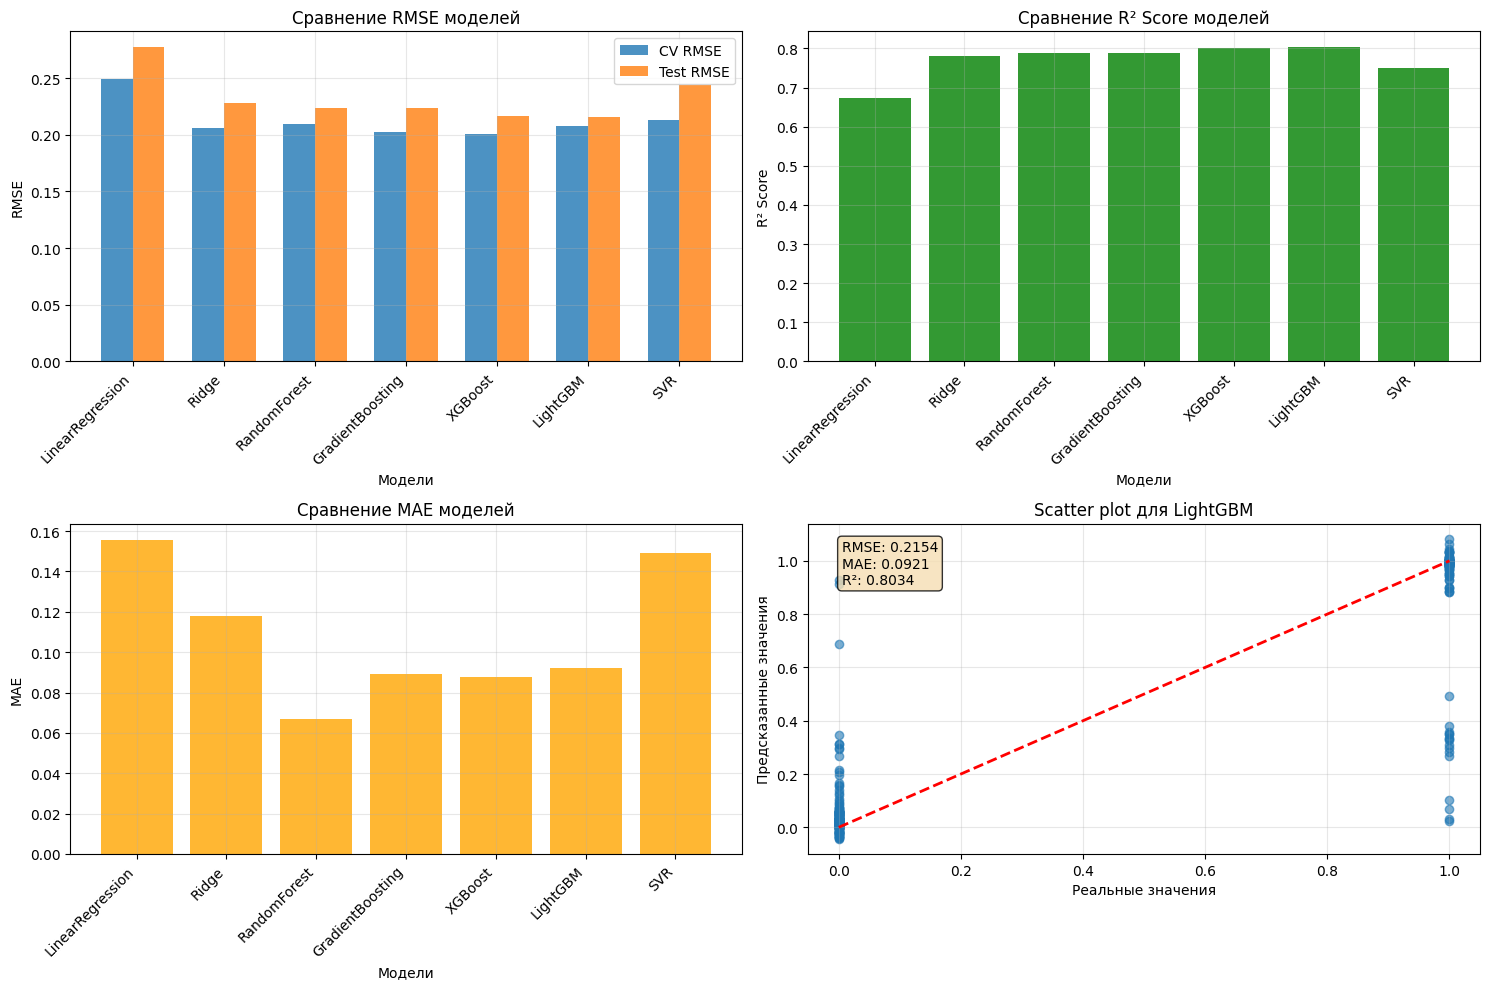

In [73]:
if results:
    # Создаем папку для сохранения, если еенет
    save_dir = 'res'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Создана директория: {save_dir}")
        
    # Создаем график сравнения RMSE
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Сравнение RMSE
    models_list = list(results.keys())
    cv_rmse_values = [results[m]['cv_rmse'] for m in models_list]
    test_rmse_values = [results[m]['test_rmse'] for m in models_list]
    
    x = np.arange(len(models_list))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, cv_rmse_values, width, label='CV RMSE', alpha=0.8)
    axes[0, 0].bar(x + width/2, test_rmse_values, width, label='Test RMSE', alpha=0.8)
    axes[0, 0].set_xlabel('Модели')
    axes[0, 0].set_ylabel('RMSE')
    axes[0, 0].set_title('Сравнение RMSE моделей')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(models_list, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Сравнение R²
    r2_values = [results[m]['test_r2'] for m in models_list]
    
    axes[0, 1].bar(models_list, r2_values, alpha=0.8, color='green')
    axes[0, 1].set_xlabel('Модели')
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].set_title('Сравнение R² Score моделей')
    axes[0, 1].set_xticklabels(models_list, rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Сравнение MAE
    mae_values = [results[m]['test_mae'] for m in models_list]
    
    axes[1, 0].bar(models_list, mae_values, alpha=0.8, color='orange')
    axes[1, 0].set_xlabel('Модели')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].set_title('Сравнение MAE моделей')
    axes[1, 0].set_xticklabels(models_list, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Scatter plot для лучшей модели
    if best_model_name in best_models:
        best_model = best_models[best_model_name]
        y_pred_best = best_model.predict(X_test)
        
        axes[1, 1].scatter(y_test, y_pred_best, alpha=0.6)
        axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[1, 1].set_xlabel('Реальные значения')
        axes[1, 1].set_ylabel('Предсказанные значения')
        axes[1, 1].set_title(f'Scatter plot для {best_model_name}')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Добавляем текст с метриками
        text_str = f"RMSE: {best_result['test_rmse']:.4f}\nMAE: {best_result['test_mae']:.4f}\nR²: {best_result['test_r2']:.4f}"
        axes[1, 1].text(0.05, 0.95, text_str, transform=axes[1, 1].transAxes, 
                       fontsize=10, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('res/model_comparison.jpg', dpi=300)
    plt.show()

In [74]:
# Создаем директорию для сохранения моделей
save_dir = 'res/models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Создана директория: {save_dir}")

# Сохраняем лучшую модель
if results and best_model_name in best_models:
    best_model = best_models[best_model_name]
    model_path = os.path.join(save_dir, f'best_model_{best_model_name}.pkl')
    joblib.dump(best_model, model_path)
    print(f"Лучшая модель сохранена: {model_path}")
    
    # Сохраняем препроцессор отдельно
    if hasattr(best_model, 'named_steps') and 'preprocessor' in best_model.named_steps:
        preprocessor_path = os.path.join(save_dir, 'preprocessor.pkl')
        joblib.dump(best_model.named_steps['preprocessor'], preprocessor_path)
        print(f"репроцессор сохранен: {preprocessor_path}")

Лучшая модель сохранена: res/models\best_model_LightGBM.pkl
репроцессор сохранен: res/models\preprocessor.pkl


Таким образом, был реализован файл, с помощью которого на абсолютном большинстве табличных данных можно построить базовую модель регресии, указав только таблицу и целевую переменную. Такая автоматизация процесса создания baseline модели позволит значительно ускорить разработку и эксперименты, которые понадобятся для достижения финального результата.